# An introduction to Felis and to cat qubits

Felis is the software solution developed by Alice & Bob to experiment with its core technology, cat qubits.

It is based on Qiskit, the most popular quantum computing framework.

It features several backends emulating the properties of various real or fictitious chips, but it can also execute code on real hardware ([contact us](https://alice-bob.notion.site/Contact-us-901564d5bbb94066b2553b83ea4fe482) to learn more about that).

This introductory notebook will teach you how to work with cat qubits, assuming you are already familiar with Qiskit and superconducting qubits.

Since cat qubits are made to create error-corrected logical qubits, this notebook will be split in two parts:
* The first part is about working directly with cat qubits to perform error correction
* The second part is about working with logical qubits to run algorithms

Full documentation is available at https://alice-bob.notion.site/alice-bob/Alice-Bob-Felis-documentation-52e554ccbea54e34831761f083883e49

## About Alice & Bob

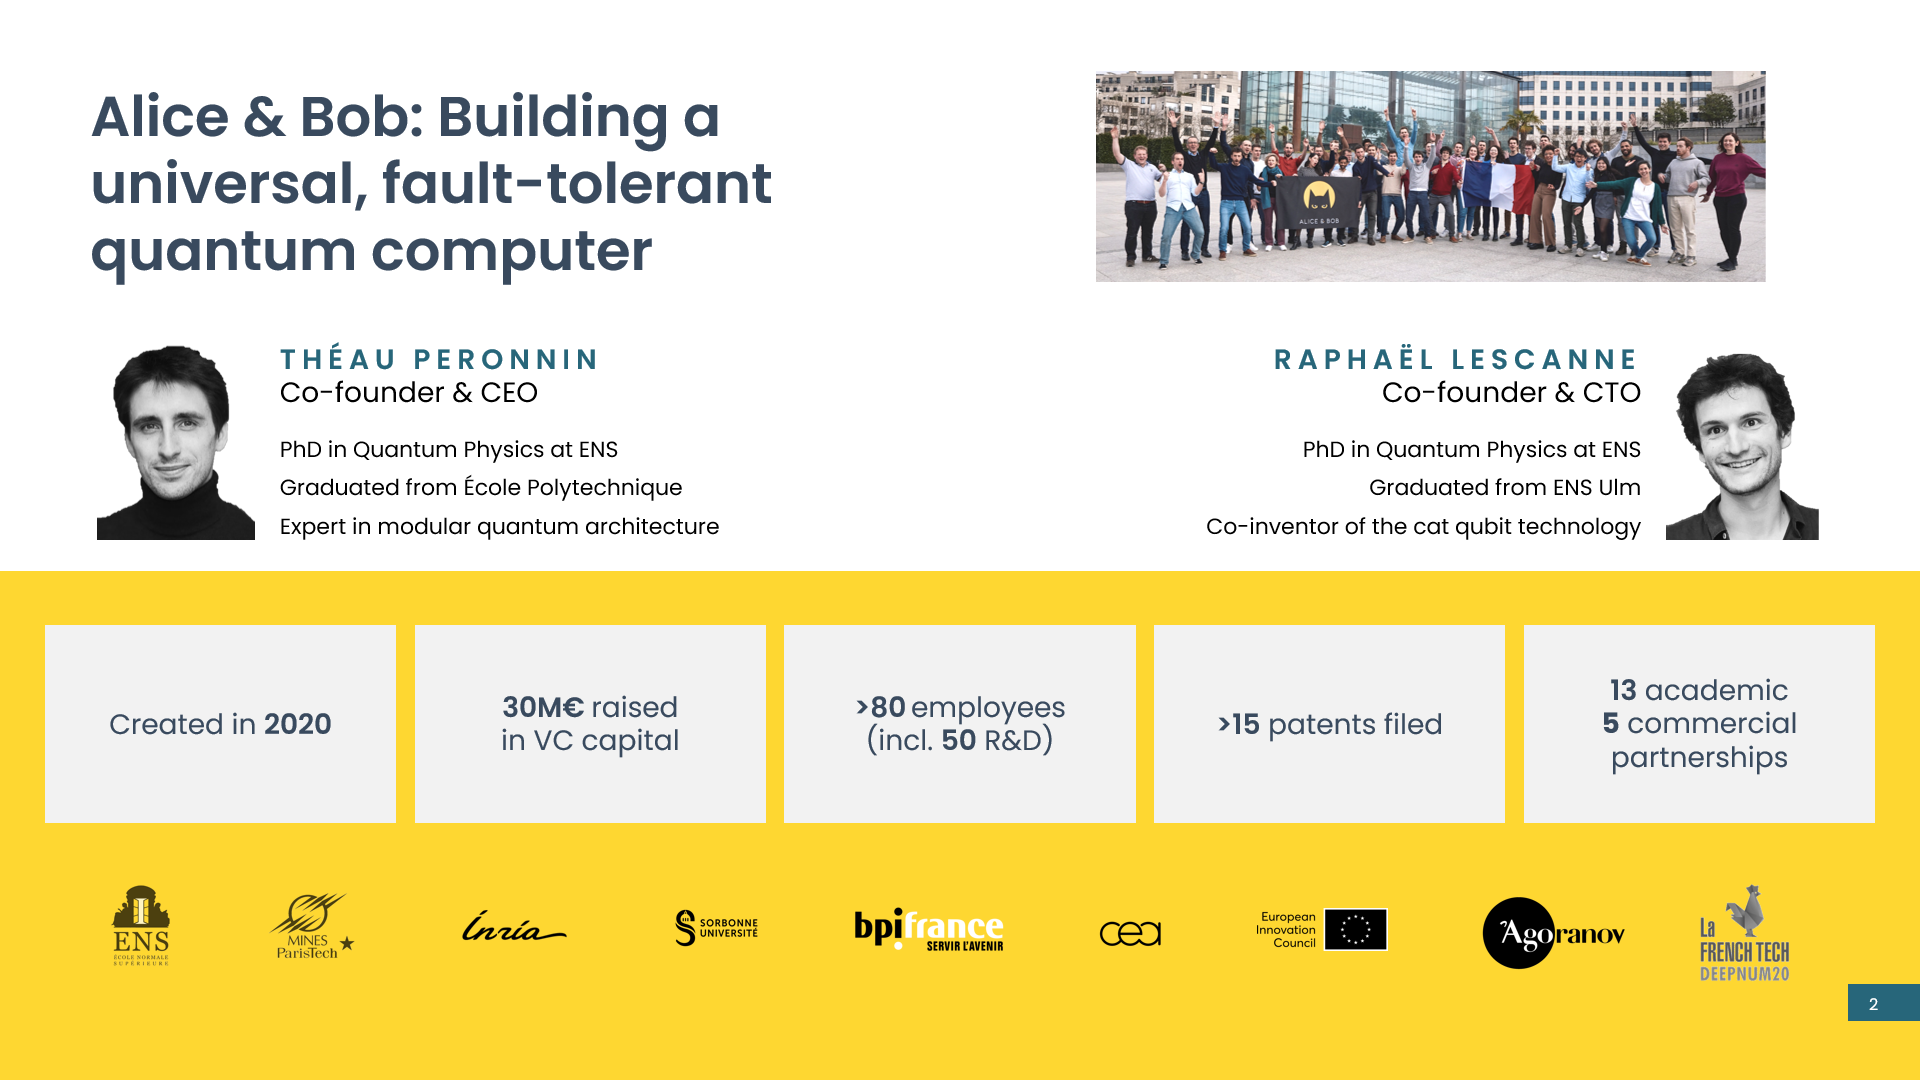

## Part 1: Use the physical mode to study error correction

### About the physical and logical modes

In the physical mode, you work directly with cat qubits: one qubit in your circuit corresponds to one cat qubit on the chip.

If you just want to run algorithms, we recommend you do **NOT** use this mode and jump to section 2 to work with logical qubits.

If you want to understand how cat qubits work and how to use them to perform error correction, please stay here!

### A quick introduction to cat qubits

You may ask: what makes cat qubits particularly well-suited to implementing error correction?

First, you need to know that two types of errors may happen in a quantum computer:
- Bit-flips (when $\ket{0}$ becomes $\ket{1}$ or the reverse)
- Phase-flips (when $\ket{+}$ becomes $\ket{-}$ or the reverse)

With traditional superconducting qubits like transmons, these two types are roughly equally likely. This means you need to deal with the two types at the same time, which is hard because you can only measure one dimension at a time.

As a result, transmons require using error correction codes like the surface code, which require a lot of qubits to create a single error-corrected logical qubit (somewhere around 1000 with strong requirements on operations fidelity).

Cat qubits are different: by tuning a specific parameter (the number of photons in a microwave cavity), their resistance to bit-flips increases exponentially while phase-flips increase only linearly. This so-called "biased noise" makes it much easier to perform error correction, since it virtually eliminates one type of errors.

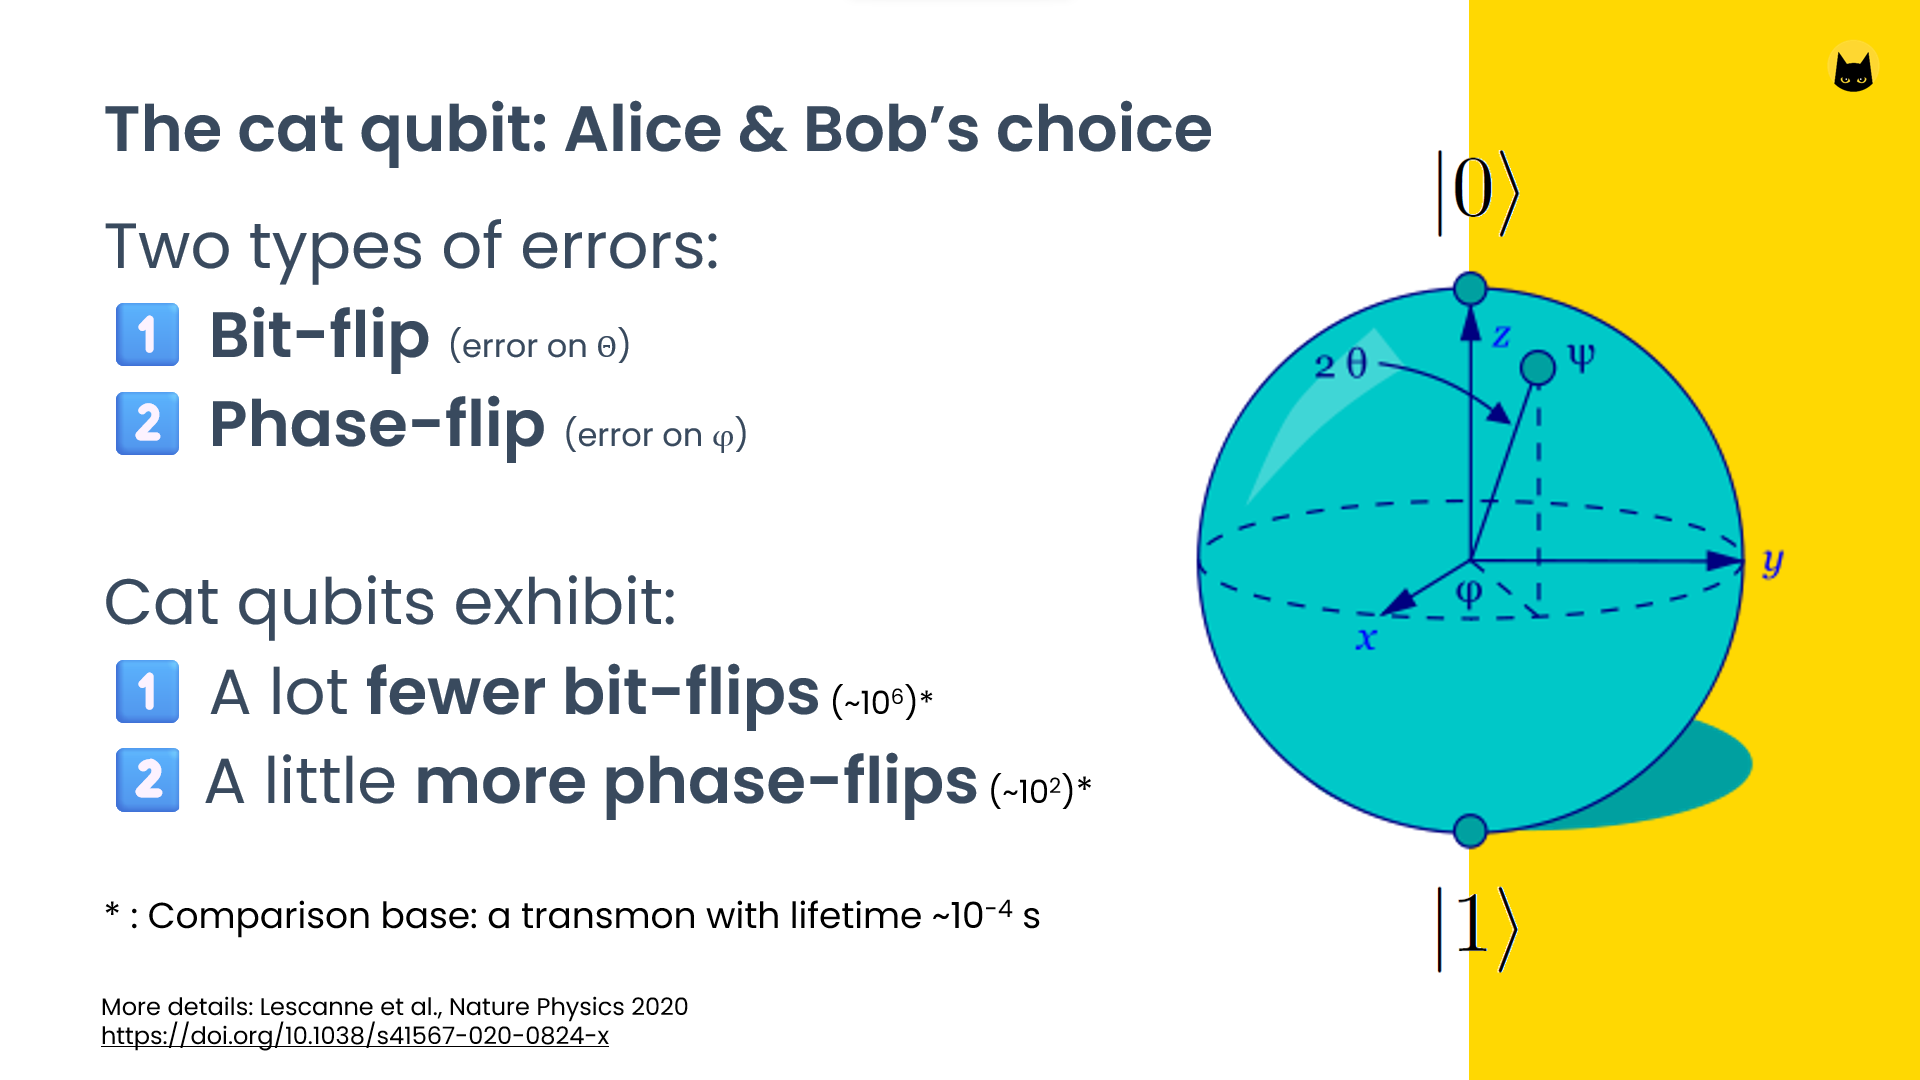

As a result, with cat qubits, the error correction code only needs to handle one type of errors. This makes it possible to use a simple repetition code, which not only requires far fewer qubits (we estimate [200 times fewer qubits than a transmon-based architecture](https://arxiv.org/abs/2401.09541)), but also has much lower requirements in terms of qubit quality (it can tolerate error rates above 10%).

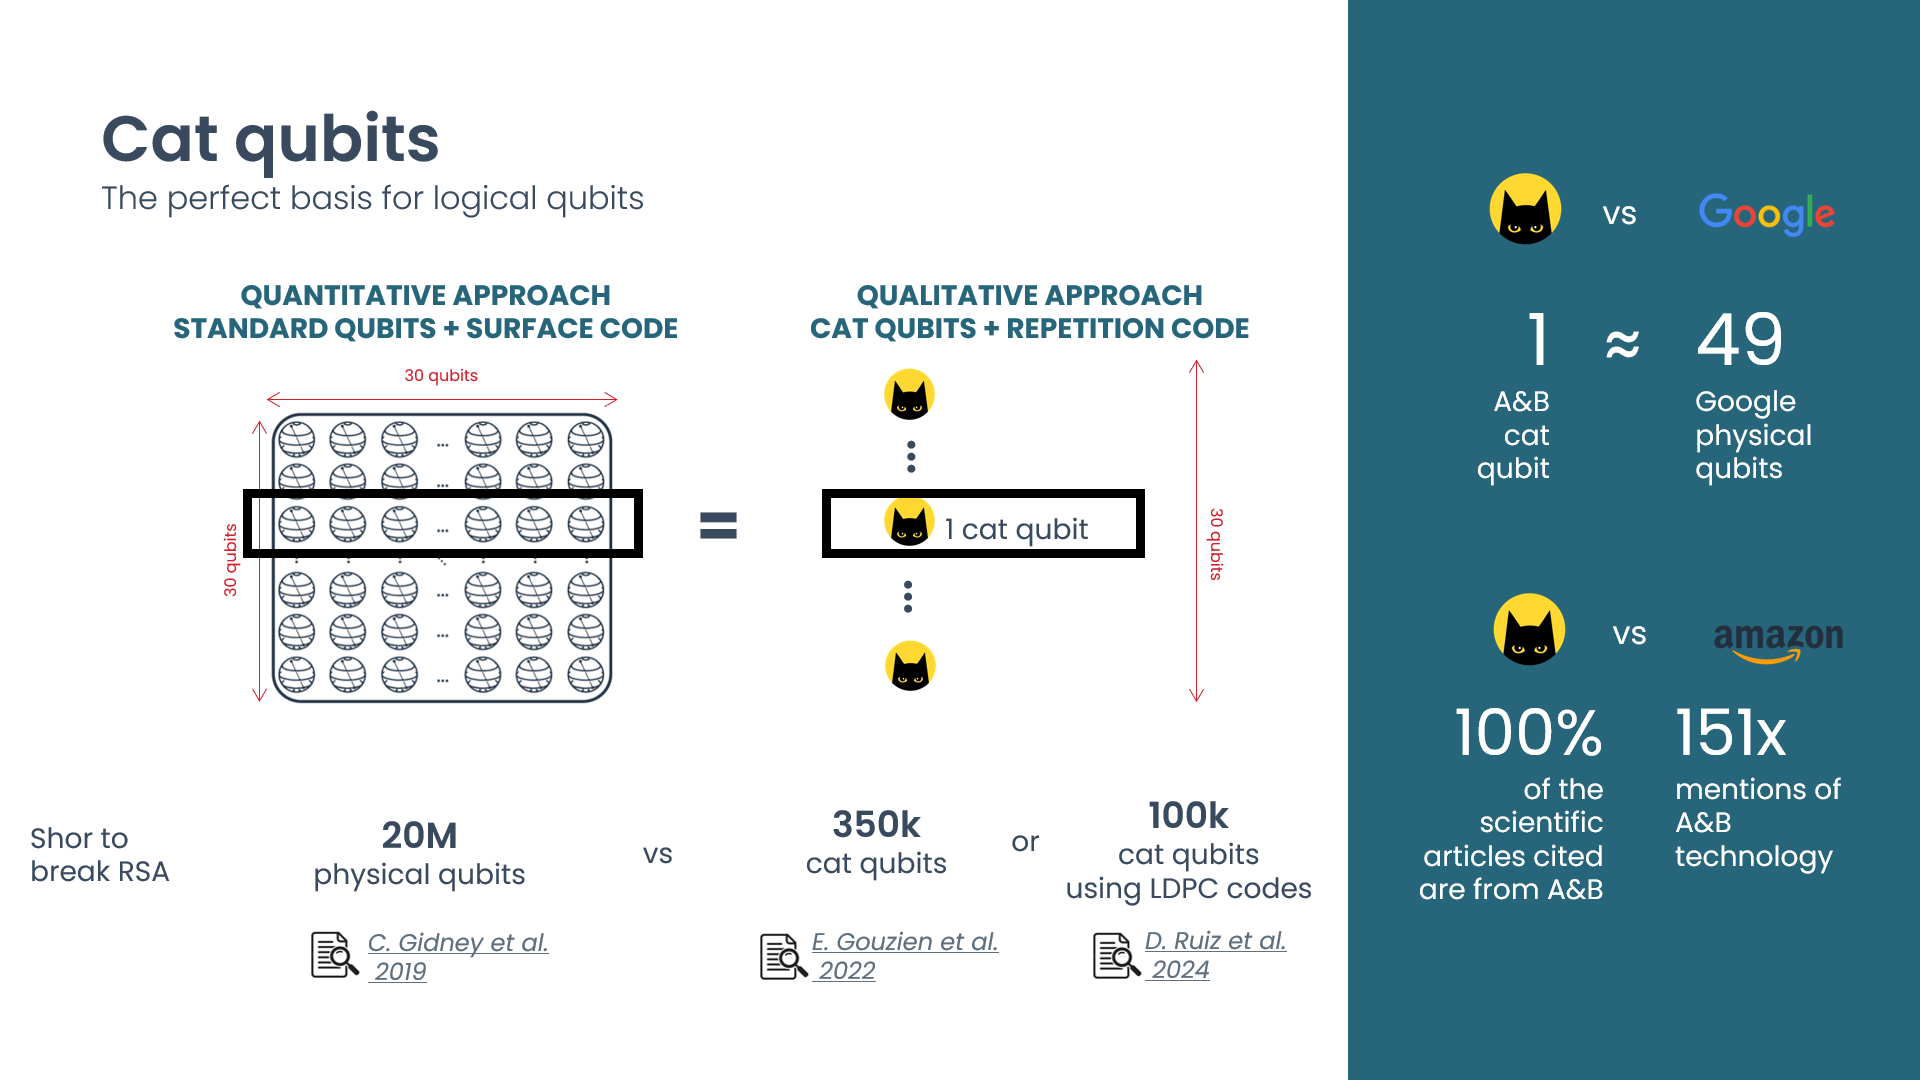

### Experiment: witness the biased noise of cat qubits

Let us start by showing how cat qubits can be tuned to efficiently suppress bit-flips.

We will build a circuit which starts from the $\ket{0}$ state, waits and measures the result.

With ideal noiseless hardware, this circuit should always return 0. But with real noisy hardware, bit-flips happen and $\ket{0}$ might into $\ket{1}$ while we wait.

We will verify cat qubits can be partly protected against this effect.

For this purpose, we will use a model replicating the behavior of the qubit presented in our [seminal Nature paper in 2020](https://arxiv.org/pdf/1907.11729.pdf).

While this design from 2019 already perfectly demonstrates our points, we will update this tutorial with a more recent design exhibiting far better performance.

#### Preliminary: Importing Felis and initializing dependencies

In [1]:
from qiskit_alice_bob_provider.local.provider import AliceBobLocalProvider
from qiskit import QuantumCircuit, execute, transpile
from qiskit.visualization import plot_histogram
from qiskit.providers.fake_provider import FakeVigo
from qiskit_aer import AerSimulator
import matplotlib.pyplot as mp
from typing import Optional

In the cell below, we get the list of available backends and display them.

The backends are documented at https://alice-bob.notion.site/Backends-091d86f10d2c46009b9c5ebcd7b18d09

In [2]:
provider = AliceBobLocalProvider()

provider.backends()

[<ProcessorSimulator(name=EMU:6Q:PHYSICAL_CATS)>,
 <ProcessorSimulator(name=EMU:40Q:PHYSICAL_CATS)>,
 <ProcessorSimulator(name=EMU:40Q:LOGICAL_TARGET)>,
 <ProcessorSimulator(name=EMU:15Q:LOGICAL_EARLY)>,
 <ProcessorSimulator(name=EMU:1Q:LESCANNE_2020)>]

#### A bit-flip detection circuit

In [3]:
def build_bit_flip_circuit(delay_duration_us: float) -> QuantumCircuit:
    circ = QuantumCircuit(1, 1)
    circ.reset(0)
    circ.delay(delay_duration_us, 0, unit='us')
    circ.measure(0, 0)
    return circ

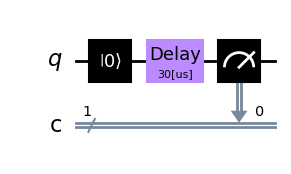

In [4]:
circ = build_bit_flip_circuit(30)
circ.draw('mpl')

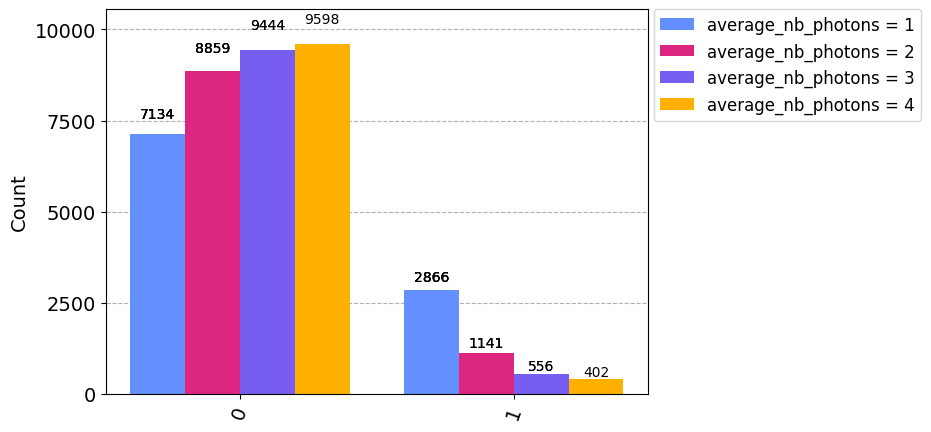

In [5]:
counts = []
shots = 10000
sweep_range = range(1,5)

for nb_photons in range(1,5):
    backend = provider.get_backend('EMU:1Q:LESCANNE_2020', average_nb_photons=nb_photons)
    job = execute(circ, backend, shots=shots)
    counts.append(job.result().get_counts())

plot_histogram(counts, legend = ["average_nb_photons = %i" % i for i in sweep_range])

As expected, we can see that the share of right results increases in a way that looks exponential (and which is proved to be exponential in notebook #1).

It doesn't increase all the way to 1 though, because the results of this experiment are also affected by the fidelity of the measurement and of the state preparation.

This is why we're adding a delay in our circuit: it makes bit-flips the dominant source of errors and enables you to witness the effect of tuning the number of photons.

Notebook #1 dives deeper into this topic and measures how bit-flip lifetime changes by changing the delay and fitting a curve.

We will now look at the effect of the number of photons over phase-flips. This time, we expect to see error rates increase together with the number of photons.

In [6]:
def build_phase_flip_circuit_cats(delay_duration_us: float) -> QuantumCircuit:
    circ = QuantumCircuit(1, 1)
    circ.initialize('+')
    circ.delay(delay_duration_us, 0, unit='us')
    circ.measure_x(0, 0)
    return circ

/home/lprost/.local/lib/python3.10/site-packages/qiskit/utils/classtools.py:112: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  retval = method(*args, **kwargs)


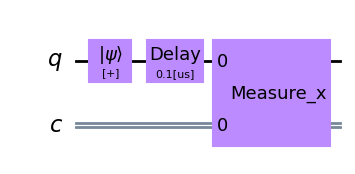

In [7]:
circ_fp = build_phase_flip_circuit_cats(0.1)
circ_fp.draw('mpl')

Note that the circuit above contains two native instructions of cat qubits: initialization in the $\ket{+}$ state, and measurement along the X axis.

On transmons, these operations are realized by adding Hadamard gates (as shown at the end of this section), but the Hadamard gate has a big issue for cat qubits: it can transform a phase-flip into a bit-flip.

For this reason, we say that the Hadamard gate is not "bias-preserving", and we do not use Hadamard gates on cat qubits. The physical mode therefore only allows bias-preserving gates.

**Note**: it remains possible to use Hadamard gates when working with logical qubits made out of cat qubits. More on that later.

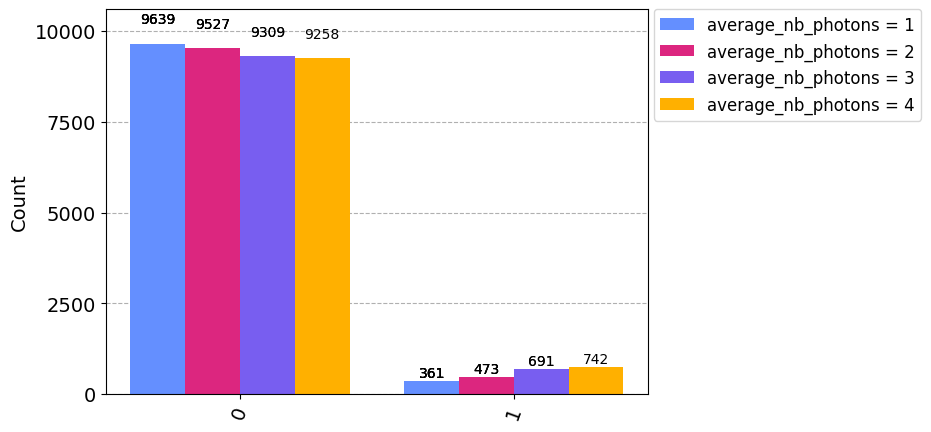

In [8]:
counts = []
shots = 10000
sweep_range = range(1,5)

for nb_photons in range(1,5):
    backend = provider.get_backend('EMU:1Q:LESCANNE_2020', average_nb_photons=nb_photons)
    job = execute(circ_fp, backend, shots=shots)
    counts.append(job.result().get_counts())

plot_histogram(counts, legend = ["average_nb_photons = %i" % i for i in sweep_range])

As expected, we can see the phase-flip rate increasing in a way that looks linear (and which is proved to be linear in notebook #1).

You'll notice we're using a much shorter delay here. This is because the phase-flip lifetime of cat qubits is quite short, about two orders of magnitude shorter than a good transmon.

This is not necessarily an issue though: cat qubits are meant to be used in an error correction code which suppresses phase-flips exponentially and can tolerate fairly high physical phase-flip rates (>10% over the duration of an error correction cycle).

So, the phase-flip rate doesn't need to be very high, it just needs to be lower than the error correction threshold of the error correction code.

The qubit from Lescanne 2020 is not that good, but the qubits we are currently working on are much closer to the threshold (less than an order of magnitude away). We will update this tutorial when we release a digital twin of one of these chips.

**Note**: an equivalent circuit on a transmon would look this way:

In [9]:
def build_phase_flip_circuit_transmons(delay_duration_us: float) -> QuantumCircuit:
    circ = QuantumCircuit(1, 1)
    circ.reset(0)
    circ.h(0)
    circ.delay(delay_duration_us, 0, unit='us')
    circ.h(0)
    circ.measure(0, 0)
    return circ

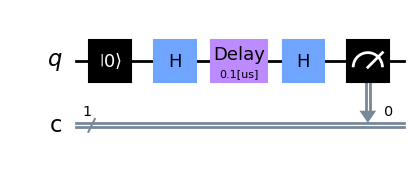

In [10]:
circ_transmons = build_phase_flip_circuit_transmons(0.1)
circ_transmons.draw('mpl')

### Using cat qubits to implement error correction

The biased noise of cat qubits makes it possible to use much simpler error correction codes.

Indeed, because quantum error correction only needs to deal with phase-flips, a repetition code focused on phase-flips makes it possible to create a logical qubit with very low noise on both dimensions.

Such a code can be implemented with the following circuit:

In [11]:
def _measurement_cycle(distance: int) -> QuantumCircuit:
    cycle = QuantumCircuit(2 * distance - 1, distance - 1, name='cycle')
    for i in range(distance - 1):
        ancilla_idx = 2 * i + 1
        cycle.initialize('+', ancilla_idx)
    for i in range(distance - 1):
        ancilla_idx = 2 * i + 1
        cycle.cx(ancilla_idx, ancilla_idx + 1)
    for i in range(distance - 1):
        ancilla_idx = 2 * i + 1
        cycle.cx(ancilla_idx, ancilla_idx - 1)
    for i in range(distance - 1):
        ancilla_idx = 2 * i + 1
        cycle.measure_x(ancilla_idx, i)
    return cycle

def error_correction_cycle(distance: int, repetitions: int, initial_state: Optional[str] = None) -> QuantumCircuit:
    if initial_state is None:
        initial_state = distance * '+'
    circuit = QuantumCircuit(2 * distance - 1, distance + repetitions * (distance - 1))
    circuit.initialize(initial_state, range(0, distance * 2, 2))
    circuit.barrier()
    for cycle_idx in range(repetitions):
        first_bit = distance + cycle_idx * (distance - 1)
        circuit.append(_measurement_cycle(distance).to_instruction(), range(2 * distance - 1), range(first_bit, first_bit + distance - 1))
        circuit.barrier()
    for i in range(distance):
        circuit.measure_x(2 * i, i)
    return circuit

/home/lprost/.local/lib/python3.10/site-packages/qiskit/utils/classtools.py:112: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  retval = method(*args, **kwargs)


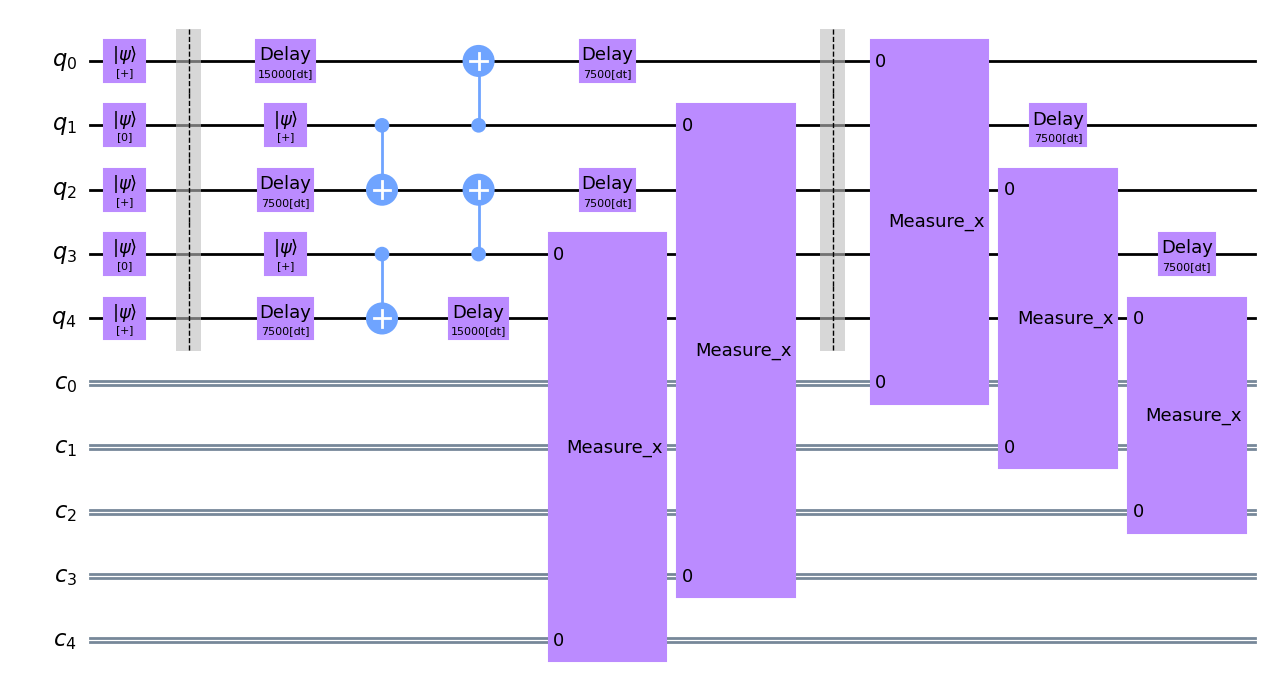

In [14]:
circ = error_correction_cycle(distance=3, repetitions=1)
backend = provider.get_backend('EMU:40Q:LOGICAL_TARGET')
transpile(circ, backend).draw('mpl')

This circuit is studied in more details in notebook #3.

## Part 2: Use the logical mode to run algorithms

Even if cat qubits require fewer physical qubits than other approaches, a chip implementing a handful of logical, error-corrected qubits is expected to require around 40-50 qubits, which is a lot for today's emulators.

Besides, you don't want to manually design error correction circuits every time you want to run an algorithm.

For these reasons, we designed "logical" backends, which abstract away error correction and reproduce the behavior of a chip featuring logical qubits.

With logical backends, each qubit in your circuit corresponds to several qubits on the chip, working together to create a higher quality qubit.

Unlike physical backends, logical backends have no restriction in terms of gates (you are allowed a Hadamard!) or in terms of connectivity (you get all-to-all connectivity, even if the physical qubits don't have it).

Logical backends are therefore ideal to run algorithms and study how they behave in the presence of noise.

Here's a simple example of how to use a logical backend to create a Bell state:

In [ ]:
from qiskit_alice_bob_provider.local.provider import AliceBobLocalProvider
from qiskit import QuantumCircuit, execute
from qiskit.visualization import plot_histogram

shots = 10000
provider = AliceBobLocalProvider()

In [ ]:
backend = provider.get_backend('EMU:15Q:LOGICAL_EARLY')

circ = QuantumCircuit(2,2)
circ.reset(0)
circ.h(0)
circ.cx(0,1)
circ.measure(0,0)
circ.measure(1,1)

circ.draw('mpl')

In [ ]:
job = execute(circ, backend, shots=shots)
plot_histogram(job.result().get_counts())

In this example, we use the `EMU:15Q:LOGICAL_EARLY` backend, which anticipates what might be the performance of one of the first chips featuring a useful number of logical qubits (15, in this case). At the time when this tutorial is written (February 2024), such chips are expected to be only a few years in the future.

You can use this backend to run any quantum algorithm, like you would use virtually any other transmon-based backend. See notebooks \#4 and \#5 of this series for more examples.

In `EMU:15Q:LOGICAL_EARLY`, we used fairly conservative hypotheses on the quality of the qubits involved, meaning you get error rates between 1e-3 and 1e-4 - this is better than any type of quantum hardware available today, but not by a large margin.

Our goal being to reach very low error rates, we have created another backend using the hypotheses of our paper estimating we will need [200 times fewer qubits than a transmon-based architecture](https://arxiv.org/abs/2401.09541): `EMU:40Q:LOGICAL_TARGET`. It will take several more years after `EMU:15Q:LOGICAL_EARLY` to reach this quality level, but it clearly illustrates the point of our approach: escape decoherence and get rid of noise!

**Disclaimer**: Neither `EMU:15Q:LOGICAL_EARLY` nor `EMU:40Q:LOGICAL_TARGET` represent a commitment by Alice & Bob to reach a certain level of performance. These backends are based on theoretical models giving a realistic expectation of how a chip working in logical mode should perform, but we still need to build the corresponding hardware and measure its performance.

## Go further!

This notebooks comes with many others to dive deeper into use cases.

In case you only got this notebook, you can retrieve the whole series at https://github.com/Alice-Bob-SW/emulation-examples

We also recommend reading the following papers:
- To learn about the physics of cat qubits: https://www.nature.com/articles/s41567-020-0824-x (also available at https://arxiv.org/abs/1907.11729)
- To learn about error correction with a repetition code: https://journals.aps.org/prx/abstract/10.1103/PhysRevX.9.041053
- To learn about a cat qubit chip featuring a 10-second bit-flip lifetime: https://arxiv.org/abs/2307.06617
- To learn about a fault-tolerant architecture running Shor's algorithm on a 2048-bit integer with only 350k cats qubits: https://arxiv.org/abs/2302.06639
- To learn about how LDPC codes can be used to build 100 logical qubits with only 1500 physical cat qubits: https://arxiv.org/abs/2401.09541